In [49]:
import pandas as pd
import xarray as xr
import xsimlab as xs
import episimlab as esl
from episimlab.models.basic import toy_partition, cy_seir_cy_foi
from episimlab.partition.toy import (
    SetupPhiWithPartitioning as SetupPhiWithPartitioning,
    InitCoords as SetupCoordsForPartitioning
)
from episimlab.setup.counts import InitDefaultCounts

# 20210209_aisd_pilot

The purpose of this notebook is to expand on the model demo'ed in the [previous notebook](20210203_test_kp_migration.ipynb). **The scientific objective is to determine whether modeling schools in AISD significantly changes disease transmission in the period of early May.** The control will be the same geographic area covered by AISD, but without including school transmission (no contextual vertices in `travel.csv`). Another good control would remove vertices completely, modeling the AISD area as a single vertex. In addition, we want to:
* Use most up-to-date epidemiological parameters, if possible. This is not a necessity, but params should be sane. These can be found in [this Google Doc](https://drive.google.com/file/d/1_W7T1rNOZC0KcAUKTYw_4xh8xRa1rns-/view?usp=sharing).
* Expose parameters in this notebook. This is easy, as it requires one to simply remove processes from the model.
* Choropleth map / animation

I will be using Episimlab `c864ab9c6ea3972937a91cce0092f8cf5ad4897e`.

----

We will start by assembling a control model, starting from `cy_seir_cy_foi` from the package. We will do this to check to ensure sane disease progression when running the simulation without any vertices (phi is a constant 0.75 from process `episimlab.setup.phi.InitPhi` and is vertex-agnostic).

In [50]:
starting_model = cy_seir_cy_foi()
starting_model

<xsimlab.Model (20 processes, 1 inputs)>
setup_coords
read_config
    config_fp     [in]
rng
sto
setup_counts
setup_beta
setup_eta
setup_gamma
setup_mu
setup_nu
setup_rho
setup_tau
setup_omega
setup_pi
setup_sigma
setup_phi_grp_mapping
setup_phi
foi
seir
apply_counts_delta

We need a process that sets up the starting population. In episimlab, this is the `counts` variable, which changes as the simulation progresses. To set the initial value, let's subclass the default process:

In [51]:
@xs.process
class SetupInitialCounts(InitDefaultCounts):
    
    def initialize(self):
        da = xr.DataArray(
            data=0.,
            dims=self.COUNTS_DIMS,
            coords={dim: getattr(self, dim) for dim in self.COUNTS_DIMS}
        )
        # Some arbitrary S populations for each node
        da.loc[dict(vertex=0, compartment='S')] = 1e5
        da.loc[dict(vertex=1, compartment='S')] = 3e5
        
        # Start with 50 infected asymp in each node
        da.loc[dict(compartment='Ia')] = 50.

        self.counts = da

We update the default processes:

In [52]:
control_model = starting_model.update_processes({'setup_coords': SetupCoordsForPartitioning, "setup_counts": SetupInitialCounts})
control_model = control_model.drop_processes('setup_beta')
control_model

<xsimlab.Model (19 processes, 5 inputs)>
setup_coords
    n_age         [in]
    n_nodes       [in]
    n_risk        [in]
read_config
    config_fp     [in]
rng
sto
setup_counts
setup_eta
setup_gamma
setup_mu
setup_nu
setup_rho
setup_tau
setup_omega
setup_pi
setup_sigma
setup_phi_grp_mapping
setup_phi
foi
    beta          [in]
seir
apply_counts_delta

With these updates to the setup processes, we see that the model now requires 3 inputs:

In [53]:
control_model.setup_phi

<InitPhi 'setup_phi' (xsimlab process)>
Variables:
    phi_grp1            [in] <--- setup_phi_grp_mapping.phi_grp1
    phi_grp2            [in] <--- setup_phi_grp_mapping.phi_grp2
    phi_grp_mapping     [in] <--- setup_phi_grp_mapping.phi_grp_map...
    phi                [out] ('phi_grp1', 'phi_grp2') 
    phi_t              [out] ('phi_grp1', 'phi_grp2') 
Simulation stages:
    initialize
    run_step

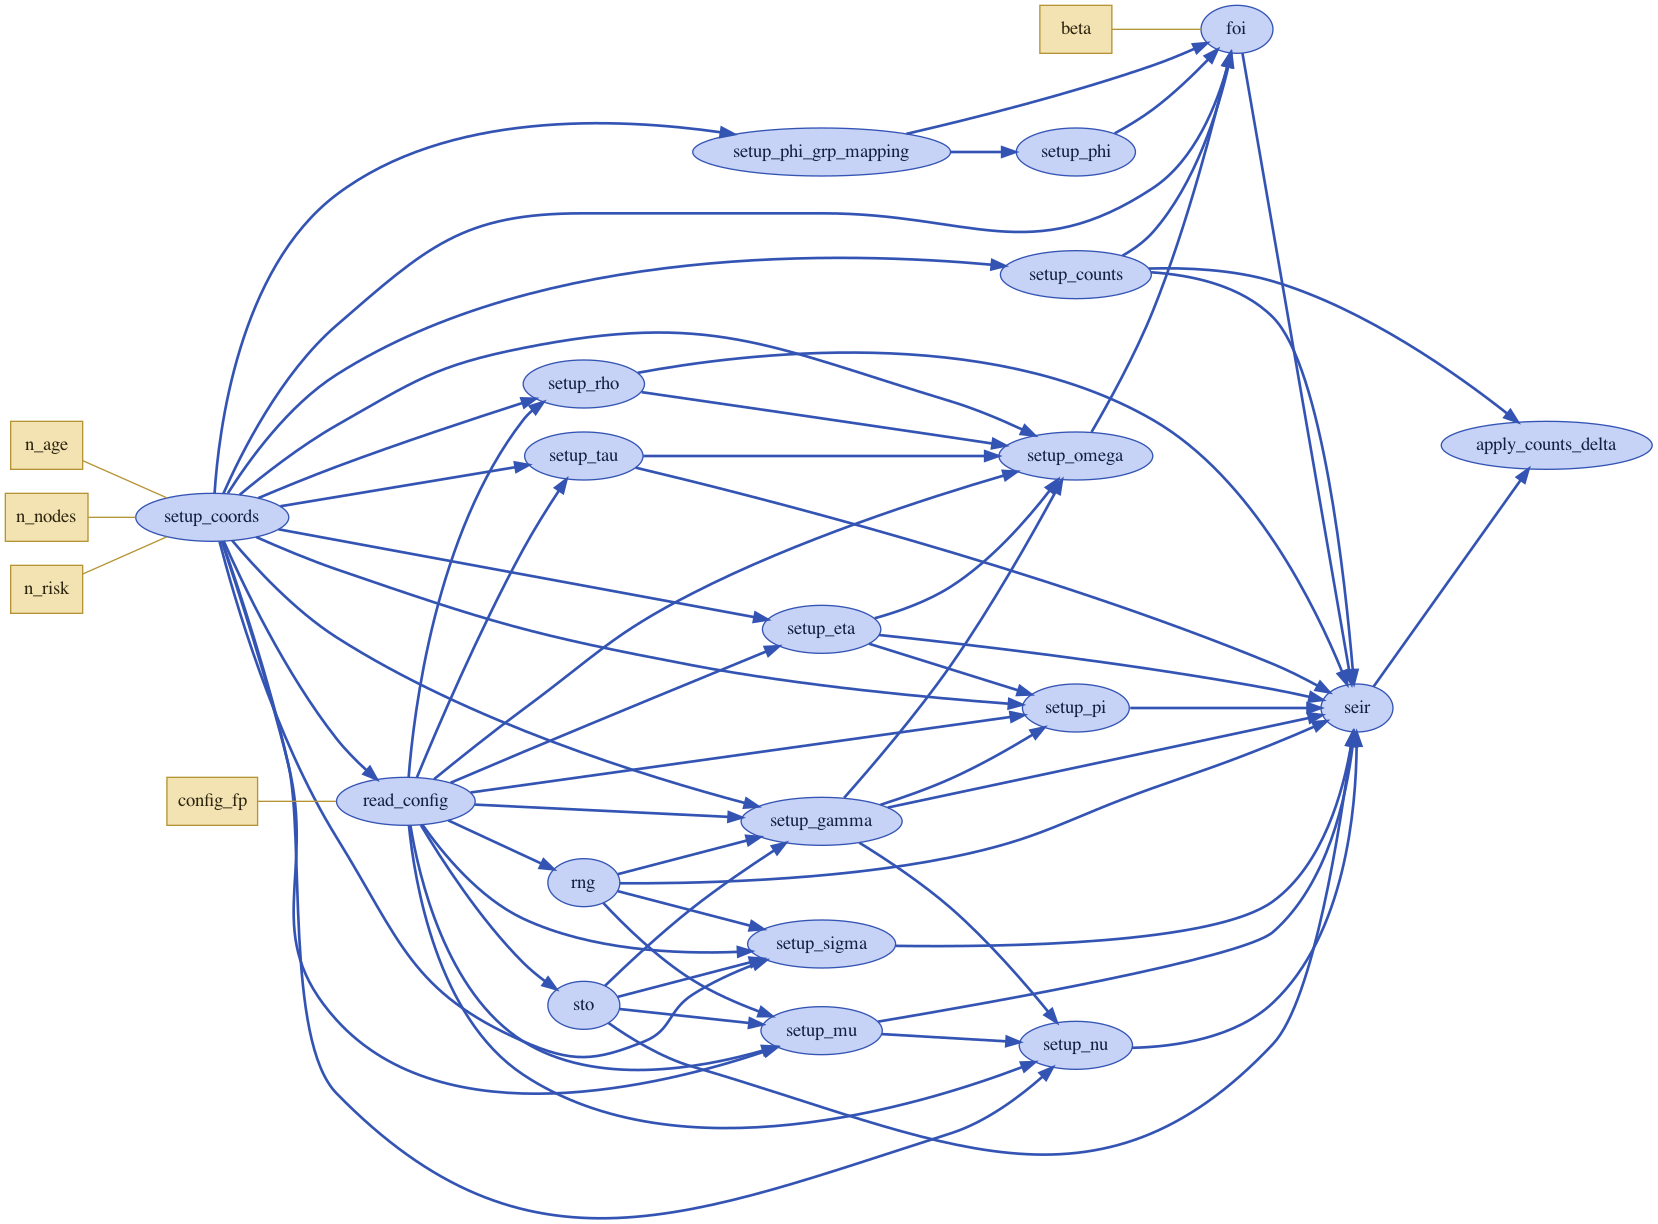

In [54]:
control_model.visualize(show_inputs=True)

# Parameter Sync

Next, let's write a configuration YAML file and pass its path as the `config_fp` input variable. The format accepted by the `read_config` process looks like [../tests/config/example_v1.yaml](../tests/config/example_v1.yaml). I simply copied this YAML file to this directory (examples/20210209_example_v1.yaml) so we can edit it.

Now, let's ensure that the parameters in this config file are synced with the [most recent parameter set in the Google Doc](https://drive.google.com/file/d/1_W7T1rNOZC0KcAUKTYw_4xh8xRa1rns-/view?usp=sharing).

Discrepancies & unknown:
* Omega for Ia: triangular(0.29, 0.29, 1.4)
* Fatality ratios: IFR and YFR
    * We do not need to model these explicitly? Isn't it the case that all Ia and Iy must pass through Ih before moving to D?
* YHR: symptomatic case hospitalization rate
    * I believe this translates to `symp_h_ratio_w_risk`, which is used to calculate `pi`
    * There was a discrepancy between GDoc and example config values, which I set to the GDoc values.
* `symp_h_ratio`: used to determine `omega`, not explicitly listed in GDoc

These parameters were strictly tested against the parameters used in SEIRcity v2.

----

Now let's set up the rest of the input parameters:

In [62]:
config_fp = './20210209_example_v1.yaml'
input_vars = {
    'read_config__config_fp': config_fp,
    'setup_coords__n_age': 5,
    'setup_coords__n_nodes': 2,
    'setup_coords__n_risk': 2,
    'foi__beta': 0.025
}
output_vars = {
    'apply_counts_delta__counts': 'step'
}
step_clock = {
    'step': pd.date_range(
        start='5/1/2020', end='5/30/2020', freq='2H'
    )
}

Convenience function that wraps xsimlab.run:

In [63]:
def run_model(model, step_clock, input_vars, output_vars):
    input_ds = xs.create_setup(
        model=model,
        clocks=step_clock,
        input_vars=input_vars,
        output_vars=output_vars
    )
    return input_ds.xsimlab.run(model=model, decoding=dict(mask_and_scale=False))

Run the model.

In [64]:
control_result = run_model(control_model, step_clock, input_vars, output_vars)
assert isinstance(control_result, xr.Dataset)

In [65]:
control_result

<xarray.Dataset>
Dimensions:                     (age_group: 5, compartment: 16, phi_grp1: 20, phi_grp2: 20, risk_group: 2, step: 349, vertex: 2)
Coordinates:
  * age_group                   (age_group) int64 0 1 2 3 4
  * compartment                 (compartment) <U5 'S' 'E' 'Pa' ... 'Iy2Ih' 'H2D'
  * phi_grp1                    (phi_grp1) int64 0 1 2 3 4 5 ... 15 16 17 18 19
  * phi_grp2                    (phi_grp2) int64 0 1 2 3 4 5 ... 15 16 17 18 19
  * risk_group                  (risk_group) int64 0 1
  * step                        (step) datetime64[ns] 2020-05-01 ... 2020-05-30
  * vertex                      (vertex) int64 0 1
Data variables:
    apply_counts_delta__counts  (step, vertex, age_group, risk_group, compartment) float64 ...
    foi__beta                   float64 0.025
    read_config__config_fp      <U26 './20210209_example_v1.yaml'
    setup_coords__n_age         int64 5
    setup_coords__n_nodes       int64 2
    setup_coords__n_risk        int64 2

## Plotting

Let's try plotting these results:

In [66]:
def xr_viz(data_array, sel=dict(), isel=dict(),
           timeslice=slice(0, None),
           sum_over=['risk_group', 'age_group']):
    """Uses DataArray.plot, which builds on mpl
    """
    assert isinstance(data_array, xr.DataArray)
    isel.update({'step': timeslice})
    da = data_array[isel].loc[sel].sum(dim=sum_over)
    _ = da.plot.line(x='step', aspect=2, size=7)

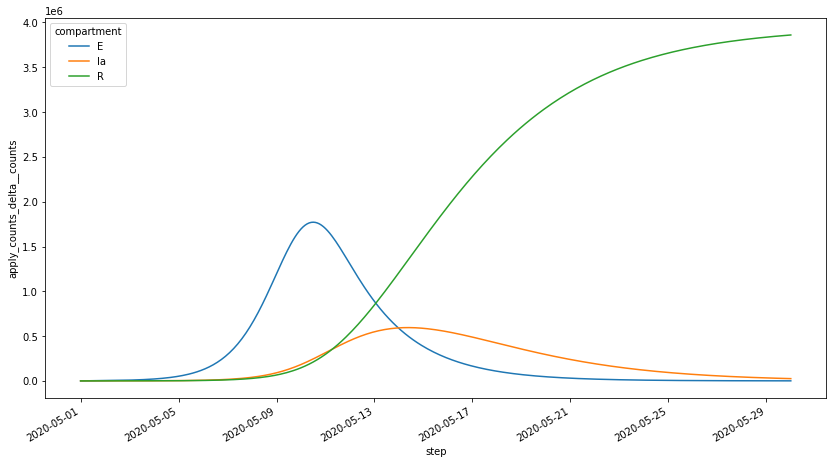

In [67]:
xr_viz(control_result['apply_counts_delta__counts'], sum_over=['vertex', 'age_group', 'risk_group'], sel=dict(compartment=['E', 'Ia', 'R']))

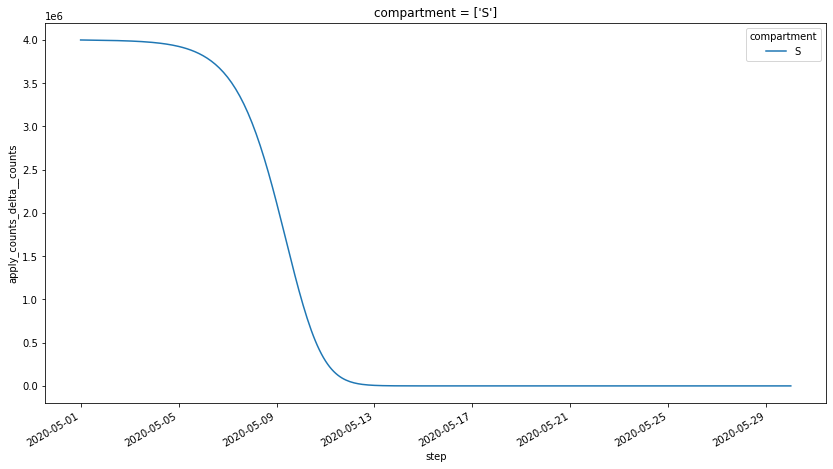

In [68]:
xr_viz(control_result['apply_counts_delta__counts'], sum_over=['vertex', 'age_group', 'risk_group'], sel=dict(compartment=['S']))